In [4]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pytensor.tensor as pt

# =========================
# Global style: Arial + transparent
# =========================
plt.rcParams.update({
    "font.family": "Arial",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Arial",
    "mathtext.it": "Arial:italic",
    "mathtext.bf": "Arial:bold",
})

# -------------------------
# Simulate example data
# -------------------------
np.random.seed(42)
num_points = 1000
time = np.linspace(0, 24, num_points)

mu_alpha_true = 0.5
mu_sin_true = 2.0
mu_cos_true = 1.5
phi_alpha_true = 2.0
phi_sin_true = 1.0
phi_cos_true = 0.5

linear_mu_true = mu_alpha_true + mu_sin_true*np.sin(2*np.pi*time/24) + mu_cos_true*np.cos(2*np.pi*time/24)
mu_true = 1 / (1 + np.exp(-linear_mu_true))

linear_phi_true = phi_alpha_true + phi_sin_true*np.sin(2*np.pi*time/24) + phi_cos_true*np.cos(2*np.pi*time/24)
phi_true = np.log1p(np.exp(linear_phi_true))

alpha_beta_true = mu_true * phi_true
beta_beta_true = (1 - mu_true) * phi_true

activity = np.random.beta(alpha_beta_true, beta_beta_true)

# -------------------------
# Build and fit model
# -------------------------
with pm.Model() as model:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1)
    mu_sin   = pm.Normal("mu_sin",   mu=2, sigma=1)
    mu_cos   = pm.Normal("mu_cos",   mu=2, sigma=1)

    phi_alpha = pm.Normal("phi_alpha", mu=1, sigma=1)
    phi_sin   = pm.Normal("phi_sin",   mu=1, sigma=1)
    phi_cos   = pm.Normal("phi_cos",   mu=0, sigma=1)

    linear_mu = mu_alpha + mu_sin * np.sin(2*np.pi*time/24) + mu_cos * np.cos(2*np.pi*time/24)
    mu = pm.Deterministic("mu", pm.math.sigmoid(linear_mu))

    linear_phi = phi_alpha + phi_sin * np.sin(2*np.pi*time/24) + phi_cos * np.cos(2*np.pi*time/24)
    phi = pm.Deterministic("phi", pt.softplus(linear_phi))

    alpha_beta = pm.Deterministic("alpha_beta", mu * phi)
    beta_beta  = pm.Deterministic("beta_beta", (1 - mu) * phi)

    activity_obs = pm.Beta("activity_obs", alpha=alpha_beta, beta=beta_beta, observed=activity)

    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["activity_obs"], return_inferencedata=False
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, mu_sin, mu_cos, phi_alpha, phi_sin, phi_cos]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [activity_obs]


Output()

/tmp/ipykernel_393889/1702278792.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi50 = az.hdi(y, hdi_prob=0.50)  # (T, 2)
/tmp/ipykernel_393889/1702278792.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi90 = az.hdi(y, hdi_prob=0.90)  # (T, 2)


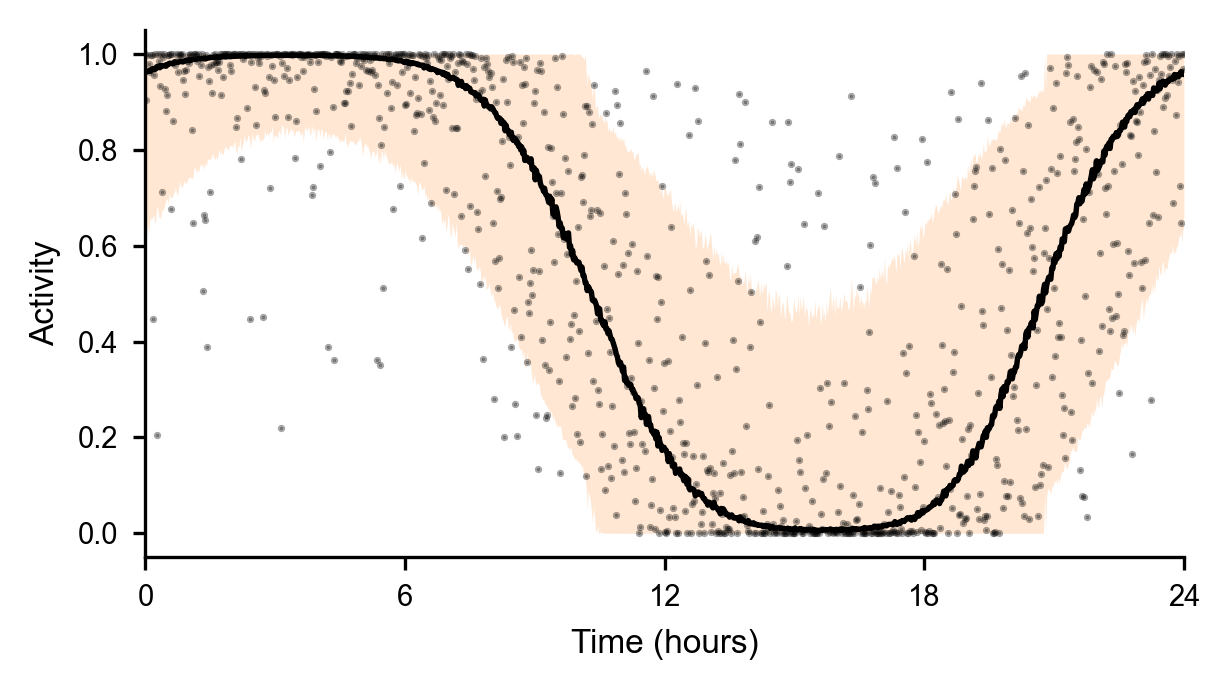

In [5]:
# posterior predictive samples: (chain, draw, time) OR sometimes (draw, time) depending on config
y = np.asarray(ppc["activity_obs"])
if y.ndim == 3:
    y = y.reshape(-1, y.shape[-1])  # (S, T)
elif y.ndim == 2:
    pass
else:
    raise ValueError(f"Unexpected posterior predictive shape: {y.shape}")

# -------------------------
# Clean plot: smaller, simpler, transparent, non-blue HDI
# -------------------------
# Use a warm/orange for bands so it doesn't clash with blue background in appendix
hdi_color = "tab:orange"

# Compute median + HDIs (choose just two bands for a cleaner look)
median = np.median(y, axis=0)
hdi50 = az.hdi(y, hdi_prob=0.50)  # (T, 2)
hdi90 = az.hdi(y, hdi_prob=0.90)  # (T, 2)

fig, ax = plt.subplots(figsize=(4.2, 2.4), dpi=300)

# Transparent backgrounds
fig.patch.set_facecolor("none")
fig.patch.set_alpha(0)
ax.set_facecolor("none")
ax.patch.set_facecolor("none")
ax.patch.set_alpha(0)

# Observations: tiny points, light
ax.plot(time, activity, ".", color="black", markersize=1.5, alpha=0.35, zorder=2)

# HDI bands (simple)
ax.fill_between(time, hdi90[:, 0], hdi90[:, 1], color=hdi_color, alpha=0.18, linewidth=0, zorder=1)

# Median line
ax.plot(time, median, color="black", linewidth=1.3, zorder=3)

# Minimal cosmetics
ax.set_xlabel("Time (hours)", fontsize=8)
ax.set_ylabel("Activity", fontsize=8)
ax.tick_params(labelsize=7, width=0.8, length=3)

# Clean spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optional: nicer x ticks for 24h
ax.set_xlim(0, 24)
ax.set_xticks([0, 6, 12, 18, 24])

# No legend (simpler). If you want a minimal one, uncomment:
# ax.legend(["Median", "90% HDI", "50% HDI", "Observed"], frameon=False, fontsize=7, loc="upper right")

fig.tight_layout()
plt.savefig("./figures/periodic_beta_fit.pdf", bbox_inches="tight", transparent=True)
plt.show()
